# Bayesian Exploration with Xopt

## TNK test function

This is the class method for running Xopt. Use Bayesian exploration to explore the input space.

TNK function
$n=2$ variables:
$x_i \in [0, \pi], i=1,2$

Objectives:
- $f_i(x) = x_i$

Constraints:
- $g_1(x) = -x_1^2 -x_2^2 + 1 + 0.1 \cos\left(16 \arctan \frac{x_1}{x_2}\right) \le 0$
- $g_2(x) = (x_1 - 1/2)^2 + (x_2-1/2)^2 \le 0.5$

In [1]:
# Import the class
from xopt import Xopt

import os
SMOKE_TEST = os.environ.get('SMOKE_TEST')

In [2]:
# To see log messages
from xopt import output_notebook
output_notebook()

The `Xopt` object can be instantiated from a JSON or YAML file, or a dict, with the proper structure.

Here we will make one

In [3]:
import yaml
# Make a proper input file. 
YAML="""
xopt: {output_path: ''}

algorithm:
  name: bayesian_exploration
  options:  
      n_initial_samples: 5
      n_steps: 5
      generator_options:                     ## options for bayesian exploration acquisition function
          batch_size: 1                      ## batch size for parallelized optimization
          #sigma: [[0.01, 0.0], [0.0,0.01]]   ## proximal biasing term
          use_gpu: False

  
simulation: 
  name: test_TNK
  evaluate: xopt.tests.evaluators.TNK.evaluate_TNK
  
vocs:
  name: TNK_test
  variables:
    x1: [0, 3.14159]
    x2: [0, 3.14159]
  objectives: {y1: None}
  constraints:
    c1: [GREATER_THAN, 0]
    c2: ['LESS_THAN', 0.5]
  linked_variables: {}
  constants: {a: dummy_constant}

"""
config = yaml.safe_load(YAML)

if SMOKE_TEST:
    config['algorithm']['options']['n_steps'] = 3
    config['algorithm']['options']['generator_options']['num_restarts'] = 2
    config['algorithm']['options']['generator_options']['raw_samples'] = 2

In [4]:
X = Xopt(config)
X

`name` keyword no longer allowed in vocs config, removing



            Xopt 
________________________________           
Version: 0.5.0+7.gc440001.dirty
Configured: True
Config as YAML:
xopt: {output_path: ''}
algorithm:
  name: bayesian_exploration
  options:
    n_initial_samples: 5
    n_steps: 5
    generator_options: {batch_size: 1, use_gpu: false}
  function: xopt.bayesian.algorithms.bayesian_exploration
simulation:
  name: test_TNK
  evaluate: xopt.tests.evaluators.TNK.evaluate_TNK
  options: {extra_option: abc}
vocs:
  variables:
    x1: [0, 3.14159]
    x2: [0, 3.14159]
  objectives: {y1: None}
  constraints:
    c1: [GREATER_THAN, 0]
    c2: [LESS_THAN, 0.5]
  linked_variables: {}
  constants: {a: dummy_constant}

# Run BayesOpt

In [5]:
# Pick one of these
from concurrent.futures import ThreadPoolExecutor as PoolExecutor
#from concurrent.futures import ProcessPoolExecutor as PoolExecutor

executor = PoolExecutor()
# This will also work. 
#executor=None

In [6]:
# Change max generations
X.run(executor=executor)

# Plot
- plot input space samples -> yellow points satisfy constraints and purple points do not

dict_keys(['variables', 'objectives', 'corrected_objectives', 'constraint_status', 'feasibility', 'model', 'constraints', 'corrected_constraints'])


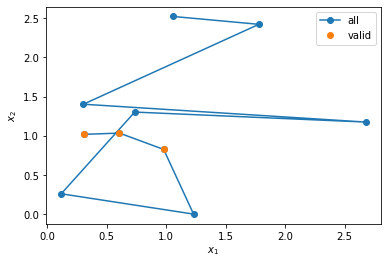

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline

# plot exploration results and path - exploration should explore the feasible region of the TNK problem - See Table V in https://www.iitk.ac.in/kangal/Deb_NSGA-II.pdf
fig, ax = plt.subplots()

results = X.results
print(results.keys())
variables = results['variables']
valid = results['variables'][results['feasibility'].flatten()]
ax.plot(variables[:, 0], variables[:, 1], '-o', label = 'all')
ax.plot(valid[:, 0], valid[:, 1], 'o', label = 'valid')
ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$')
ax.legend()

plt.show()

## Use restart file
Use a restart file to run the rest of bayesian exploration.

In [8]:
config['algorithm']['options']['restart_file'] = 'results.json'
config['algorithm']['options']['n_steps'] = 5
X = Xopt(config)
X.run()

`name` keyword no longer allowed in vocs config, removing


# Plot
- plot input space samples -> yellow points satisfy constraints and purple points do not

dict_keys(['variables', 'objectives', 'corrected_objectives', 'constraint_status', 'feasibility', 'model', 'constraints', 'corrected_constraints'])


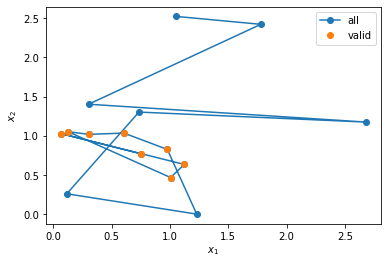

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline

# plot exploration results and path - exploration should explore the feasible region of the TNK problem - See Table V in https://www.iitk.ac.in/kangal/Deb_NSGA-II.pdf
fig, ax = plt.subplots()

results = X.results
print(results.keys())
variables = results['variables']
valid = results['variables'][results['feasibility'].flatten()]
ax.plot(variables[:, 0], variables[:, 1], '-o', label = 'all')
ax.plot(valid[:, 0], valid[:, 1], 'o', label = 'valid')
ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$')
ax.legend()

plt.show()